In [132]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from dataloader.dataloader import DataLoader
from preprocessing.clustering_segmentation import ClusteringSegmentation
from preprocessing.edge_detection import EdgeDetection
from preprocessing.image_restoration import ImageRestorer
from preprocessing.preproccessing import ImagePreprocessor
from preprocessing.region_segmentation import RegionBasedSegmentation
from preprocessing.threshold_segmentation import ThresholdSegmentation
from feature_extraction.feature_extraction import FeatureExtractor
# from feature_selection.feature_selection import FeatureSelection
# from model.model import Model
# from performance_analysis.performance_analysis import PerformanceAnalysis



import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

In [2]:
dataloader = DataLoader(Path('./data'))
X_train, y_train, X_test, y_test, X_val, y_val = dataloader.loadData()

Image data\men\2\2_men (107).JPG is corrupted
Image data\men\2\2_men (108).JPG is corrupted
Image data\men\3\3_men (140).JPG is corrupted
Image data\men\3\3_men (141).JPG is corrupted
Image data\men\4\4_men (5).JPG is corrupted
Image data\men\4\4_men (6).JPG is corrupted


In [3]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (1265, 224, 224, 3)
y_train shape: (1265,)
X_test shape: (278, 224, 224, 3)
y_test shape: (278,)
X_val shape: (278, 224, 224, 3)
y_val shape: (278,)


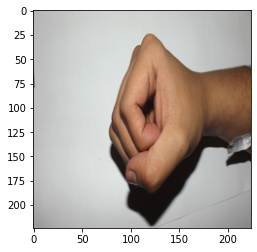

In [25]:
plt.imshow(X_train[0])
plt.show()

## Preprocessing

c:\Users\EGYPT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


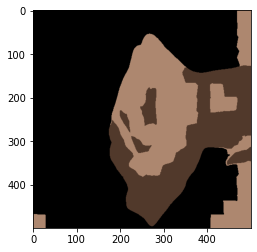

In [23]:
clustering_segmentation = ClusteringSegmentation(method='kmeans', n_clusters=3, compactness=30.0, sigma=1.0)
plt.imshow(clustering_segmentation.process(X_train[0]))
plt.show()

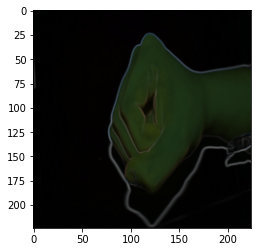

In [36]:
edge_detection = EdgeDetection(method='sobel')
#method: for roberts and canny: image must be 2D
plt.imshow(edge_detection.process(X_train[0]))
plt.show()

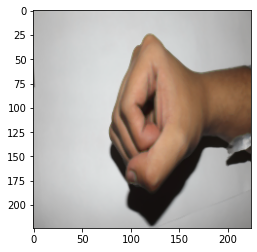

In [140]:
image_restorer = ImageRestorer(method='median')
#'mean_rectangular', 'gaussian', 'adaptive' and 'wiener' generate an error
plt.imshow(image_restorer.process(X_train[0]))
plt.show()

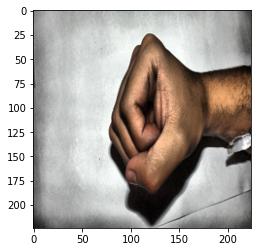

In [103]:
image_preprocessor = ImagePreprocessor(method = 'CLAHE')
# method = 'log' generates an error
plt.imshow(image_preprocessor.process(X_train[0]))
plt.show()

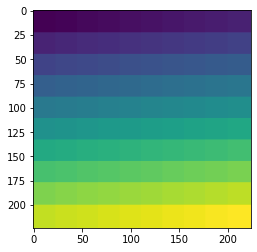

In [106]:
region_based_segmentation = RegionBasedSegmentation(method='region_merging')
# method: 'region_splitting' generates an error
plt.imshow(region_based_segmentation.process(X_train[0]))
plt.show()

## Features Extraction

In [158]:
feature_extractor = FeatureExtractor()

# HOG FEATURES
hog_features = []
for i in range(10):
    hog_features.append(feature_extractor.extract_hog_features(X_train[i]))
hog_features = np.array(hog_features)
print(f"hog_features shape: {hog_features.shape}")

# LCP FEATURES
lbp_features = []
for i in range(10):
    lbp_features.append(feature_extractor.extract_lbp_features(rgb2gray(X_train[i])))
lbp_features = np.array(lbp_features)
print(f"lbp_features shape: {lbp_features.shape}")

# PCA FEATURES
pca_features = []
for i in range(10):
    pca_features.append(feature_extractor.extract_pca_features(X_train[i]))
pca_features = np.array(pca_features)
print(f"pca_features shape: {pca_features.shape}")


# SIFT FEATURES (error)
# sift_features = []
# for i in range(10):
#     sift_features.append(feature_extractor.extract_sift_features(X_train[i]))
# sift_features = np.array(sift_features)
# print(f"sift_features shape: {sift_features.shape}")

# FOURIER DESCRIPTOR FEATURES (error)
# fourier_descriptor_features = []
# for i in range(10):
#     fourier_descriptor_features.append(feature_extractor.extract_fourier_descriptor_features(X_train[i]))
# fourier_descriptor_features = np.array(fourier_descriptor_features)
# print(f"fourier_descriptor_features shape: {fourier_descriptor_features.shape}")

# SURF FEATURES (error)

surf_features = []
# for i in range(10):
#     surf_features.append(feature_extractor.extract_surf_features(X_train[i]))
# surf_features = np.array(surf_features)
# print(f"surf_features shape: {surf_features.shape}")

d:\Senior II\Pattern Recognition\Project\Project-Pattern-Recognition\feature_extraction\feature_extraction.py:47: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_features = hog(images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),


hog_features shape: (10, 26244)
lbp_features shape: (10, 224, 224)
pca_features shape: (10, 224, 20)
